### packages & data

In [1]:
library(dplyr)
library(ggplot2)
library(FNN)
library(rpart)
library(randomForest)
library(xgboost)


다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


다음의 패키지를 부착합니다: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



다음의 패키지를 부착합니다: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [2]:
PSDS_PATH <- '/Users/youngeun/prac_stat'

loan200 <- read.csv(file.path(PSDS_PATH, 'data', 'loan200.csv'), stringsAsFactors=TRUE)
loan200$outcome <- ordered(loan200$outcome, levels=c('paid off', 'default'))

loan3000 <- read.csv(file.path(PSDS_PATH, 'data', 'loan3000.csv'), stringsAsFactors=TRUE)
loan3000$outcome <- ordered(loan3000$outcome, levels=c('paid off', 'default'))

loan_data <- read.csv(file.path(PSDS_PATH, 'data', 'loan_data.csv.gz'), stringsAsFactors=TRUE)
loan_data <- select(loan_data, -X, -status)
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))

### 6.1 KNN 

In [3]:
# record in interest: payment_inc_ratio = 9, dti = 22.5
# binary classification with KNN
newloan <- loan200[1, 2:3, drop=FALSE]
newloan

,payment_inc_ratio,dti
,<dbl>,<dbl>
1,9,22.5


In [4]:
levels(loan200[-1,1]) # total

[1] "paid off" "default"

In [5]:
# fast knn: FNN package load 했기 때문에. 안하면 내장 knn 함수로 돌아감
knn_pred <- knn(train=loan200[-1, 2:3], test=newloan, cl=loan200[-1,1], k=20)
knn_pred == 'paid off'

[1] TRUE

#### knn 결과 시각화

In [6]:
attr(knn_pred, 'nn.index') # nearest neighbor index. loan200[-1, 2:3]에서의 index 

35,182,181,85,9,169,21,199,77,55,141,31,66,163,161,112,78,46,41,139


In [7]:
attr(knn_pred, 'nn.dist') # 각 점과의 거리

0.4378799,0.8818949,0.9175105,1.655698,1.706113,1.905963,2.081356,2.416829,2.44351,2.732308,2.742454,2.86058,2.887674,2.998899,3.199122,3.214208,3.365468,3.37976,3.462634,3.541426


In [8]:
# 원래 df loan200에서의 index를 구하려면 +1 해야 함 
nearest_points <- loan200[attr(knn_pred, 'nn.index') + 1, ] 
dist <- attr(knn_pred, 'nn.dist')

In [9]:
unlist(newloan)

payment_inc_ratio               dti 
              9.0              22.5

In [10]:
circleFun <- function(center=c(0, 0), r=1, npoints=100){
  tt <- seq(0, 2 * pi, length.out=npoints - 1) # 0부터  2pi 까지의 범위를 npoints-1개의 균등한 각도로 나누기
  # 중심이 center 좌표에 있는 원
  xx <- center[1] + r * cos(tt) 
  yy <- center[2] + r * sin(tt)
  return(data.frame(x=c(xx, xx[1]), y=c(yy, yy[1]))) # 원을 닫기 위해 첫 번째 점을 다시 추가 (vector + 스칼라(얘도 벡터))
}

circle_df <- circleFun(center=unlist(newloan), r=max(dist), npoints=201) # unlist = ravel

In [11]:
head(circle_df)

,x,y
,<dbl>,<dbl>
1,12.54143,22.50000
2,12.53966,22.61180
3,12.53437,22.72348
4,12.52555,22.83495
5,12.51322,22.94608
6,12.49739,23.05676


In [12]:
loan200_df <- loan200 # bind_cols(loan200, circle_df)

In [13]:
class(loan200_df$outcome)

[1] "ordered" "factor"

In [14]:
# 요인 수준 추가 
levels(loan200_df$outcome) <- c(levels(loan200_df$outcome), "newloan")
# cell value 변경
loan200_df[1, 'outcome'] <- 'newloan'

In [15]:
head(loan200_df)

,outcome,payment_inc_ratio,dti
,<ord>,<dbl>,<dbl>
1,newloan,9.00000,22.50
2,default,5.46933,21.33
3,paid off,6.90294,8.97
4,paid off,11.14800,1.83
5,default,3.72120,10.81
6,paid off,1.89923,11.34


In [16]:
# 그래프에서 색깔이나 모양 하나의 설정으로 가려면,nearest_points에 새로운 요인(newloan)이 없어도 요인 수준 맞춰주는 게 편리
levels(nearest_points$outcome) <- levels(loan200_df$outcome)

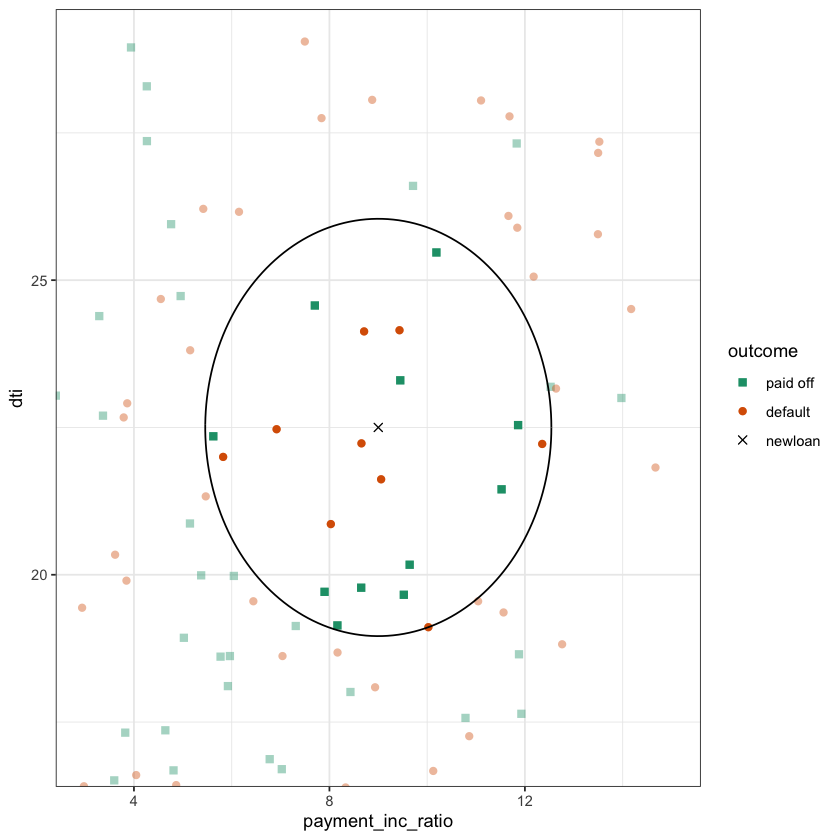

In [17]:
graph <- ggplot(data=loan200_df, aes(x=payment_inc_ratio, y=dti, color=outcome)) + # , shape=outcome)) +
  geom_point(aes(shape=outcome), size=2, alpha=0.4) +
  geom_point(data=nearest_points, aes(shape=outcome), size=2) +
  geom_point(data=loan200_df[1,], aes(shape=outcome), size=2) + # newloan
  scale_shape_manual(values=c(15, 16, 4)) + # 여기도 명시적인 label 줘도 됨
  scale_color_manual(values = c("paid off"="#1b9e77", "default"="#d95f02", "newloan"='black')) +
  geom_path(data=circle_df, aes(x=x, y=y), color='black') + # 데이터 포인트를 연결하여 경로를 그려줌
  coord_cartesian(xlim=c(3, 15), ylim=c(17, 29)) +
  theme_bw() 
graph

##### geom_line vs. geom_path

In [18]:
# 예제 데이터 프레임 생성 (순서가 중요한 데이터)
df <- data.frame(
  x = c(1, 3, 2, 5, 4),
  y = c(2, 3, 1, 5, 4)
)

# ggplot2를 사용하여 geom_line으로 선 그리기
p_line <- ggplot(df, aes(x = x, y = y)) +
  geom_line() +
  ggtitle("geom_line: Line sorted by x values")  +
  theme_minimal()

# ggplot2를 사용하여 geom_path로 경로 그리기
p_path <- ggplot(df, aes(x = x, y = y)) +
  geom_path() +
  ggtitle("geom_path: Path follows the data frame order") +
  theme_minimal()

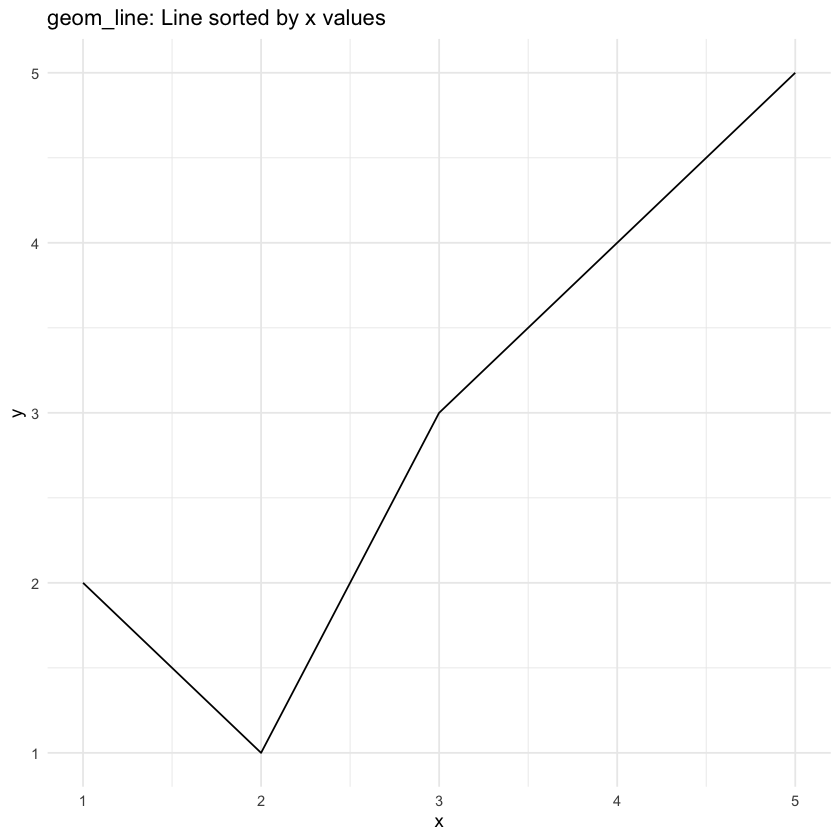

In [19]:
p_line

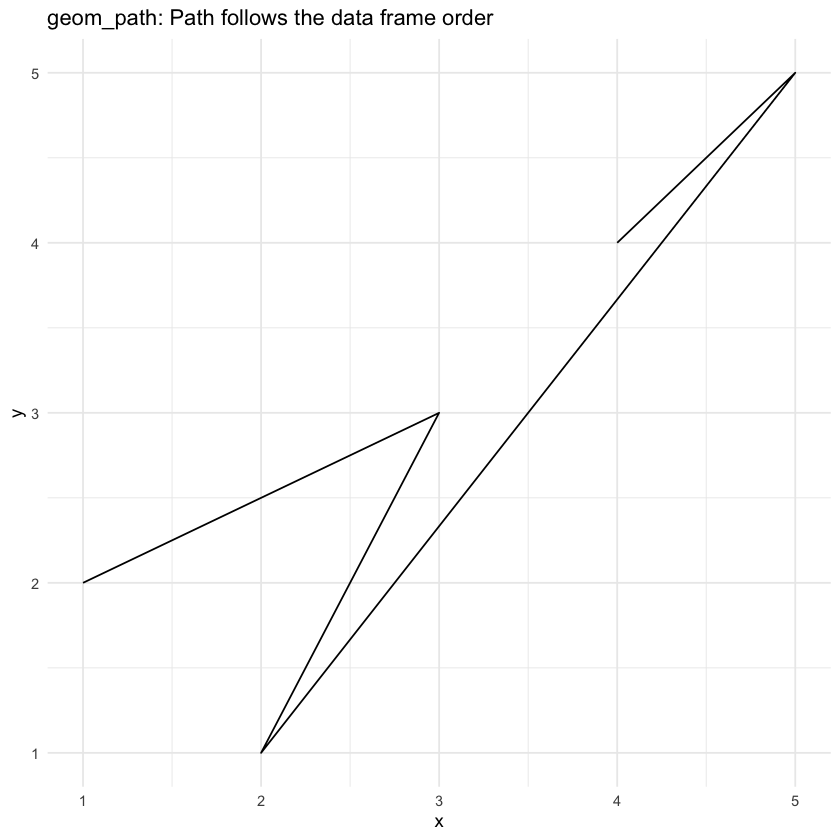

In [20]:
p_path

##### done

#### 정규화 

In [21]:
head(loan_data)

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
,<int>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<ord>,<int>,<fct>,<fct>,<fct>,<dbl>
1,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
2,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
3,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
4,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
5,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
6,21000,36 months,105000,13.22,8.01977,32135,90.3,debt_consolidation,RENT,1,1,7,5.8,default,11,debt_consolidation,RENT,> 1 Year,0.40


In [22]:
outcome_idx <- which(colnames(loan_data) == 'outcome')

In [23]:
# 예측 변수 추가 
loan_df <- model.matrix(~ -1 + payment_inc_ratio + dti + revol_bal + 
                          revol_util, data=loan_data)
newloan <- loan_df[1, , drop=FALSE] # drop=False: 서브셋이 (단일 행, 단일 열이더라도) 데이터 프레임 형식을 유지하도록 보장
loan_df <- loan_df[-1, ]
#outcome <- loan_data[-1, 1] # 첫번째 칼럼이 outcome아님. 책의 오류인듯 
outcome <- loan_data[-1, outcome_idx]
knn_pred <- knn(train=loan_df, test=newloan, cl=outcome, k=5) # cl: train_data의 y 칼럼 값 

In [24]:
loan_df[attr(knn_pred, "nn.index"),] # attr(knn_pred, "nn.index") : 최근접 이웃 index. trainset과 동일하기 때문에 인덱스 그대로 사용 가능

,payment_inc_ratio,dti,revol_bal,revol_util
35537,1.47212,1.46,1686,10.0
33652,3.38178,6.37,1688,8.4
25864,2.36303,1.39,1691,3.5
42954,1.28160,7.14,1684,3.9
43600,4.12244,8.98,1684,7.2


In [25]:
# 정규화 후 결과와 비교 
loan_df <- model.matrix(~ -1 + payment_inc_ratio + dti + revol_bal + 
                          revol_util, data=loan_data)
loan_std <- scale(loan_df)

In [26]:
head(loan_df)

,payment_inc_ratio,dti,revol_bal,revol_util
1,2.39320,1.00,1687,9.4
2,4.57170,5.55,5210,32.6
3,9.71600,18.08,9279,36.5
4,12.21520,10.08,10452,91.7
5,3.90888,7.06,11997,55.5
6,8.01977,13.22,32135,90.3


In [27]:
head(loan_std)

,payment_inc_ratio,dti,revol_bal,revol_util
1,-1.322462568,-1.9926225,-0.6558158,-1.83449837
2,-0.811561397,-1.3935348,-0.4803898,-0.92219997
3,0.394878306,0.2562606,-0.2777760,-0.76883947
4,0.980989946,-0.7970805,-0.2193670,1.40180156
5,-0.967005746,-1.1947167,-0.1424345,-0.02169853
6,-0.002921048,-0.3836441,0.8603271,1.34674907


In [28]:
newloan_std <- loan_std[1, ,drop=FALSE]
loan_std <- loan_std[-1, ]

In [29]:
loan_df <- loan_df[-1, ] # 정규화 전 원래 데이터. 나중에 inference 할 때 index 맞춰줘야 함 

In [30]:
outcome_idx <- which(colnames(loan_data) == 'outcome')

In [31]:
outcome <- loan_data[-1, outcome_idx]

In [32]:
knn_pred <- knn(train=loan_std, test=newloan_std, cl=outcome, k=5) 

In [35]:
attr(knn_pred, "nn.index")

2080,1438,30215,28542,44737


In [39]:
dim(attr(knn_pred, "nn.index"))

[1] 1 5

In [36]:
loan_df[attr(knn_pred, "nn.index")] # same as loan_df[c(c(2080, 1438, 30215, 28542, 44737))]

[1] 2.61091 2.34343 2.71200 2.39760 2.34309

In [34]:
loan_df[attr(knn_pred, "nn.index"), ] # 컴마를 붙어야 행 데이터 전체가 나온다 

,payment_inc_ratio,dti,revol_bal,revol_util
2081,2.61091,1.03,1218,9.7
1439,2.34343,0.51,278,9.9
30216,2.71200,1.34,1075,8.5
28543,2.39760,0.74,2917,7.4
44738,2.34309,1.37,488,7.2


#### KNN을 통한 피처 엔지니어링

In [42]:
borrow_df <- model.matrix(~ -1 + dti + revol_bal +revol_util + open_acc + delinq_2yrs_zero + pub_rec_zero, data=loan_data)

In [43]:
borrow_knn <- knn(borrow_df, test=borrow_df, cl=loan_data[, 'outcome'], prob=TRUE, k=20) # 확률 정보도 포함시켜라 

In [61]:
levels(borrow_knn) # 얘 자체는 클래스지만

[1] "default"  "paid off"

In [44]:
prob <- attr(borrow_knn, "prob") # 확률 정보도 얻을 수 있다 

In [54]:
prob # 각 확률은 배정되는 클래스(0이던 1이던 특정 레코드에서 다수 클래스)에 속할 확률 

[1] 0.65 0.80 0.60 0.50 0.55 0.60 0.70 0.50 0.55 0.50 0.55 0.60 0.70 0.55
   [15] 0.50 0.55 0.50 0.55 0.55 0.60 0.70 0.55 0.60 0.75 0.60 0.55 0.50 0.65
   [29] 0.60 0.55 0.55 0.55 0.65 0.75 0.50 0.65 0.60 0.55 0.55 0.65 0.65 0.50
   [43] 0.55 0.55 0.70 0.65 0.55 0.55 0.65 0.70 0.65 0.60 0.65 0.60 0.65 0.50
   [57] 0.75 0.60 0.55 0.70 0.55 0.60 0.65 0.55 0.50 0.60 0.50 0.55 0.65 0.55
   [71] 0.65 0.70 0.55 0.60 0.75 0.55 0.70 0.60 0.55 0.55 0.60 0.60 0.50 0.55
   [85] 0.65 0.50 0.75 0.55 0.55 0.60 0.60 0.65 0.50 0.70 0.65 0.55 0.70 0.55
   [99] 0.60 0.65 0.55 0.55 0.60 0.60 0.55 0.55 0.50 0.60 0.75 0.55 0.70 0.55
  [113] 0.60 0.50 0.50 0.60 0.60 0.50 0.55 0.55 0.60 0.55 0.50 0.70 0.65 0.55
  [127] 0.70 0.60 0.70 0.65 0.55 0.70 0.65 0.65 0.65 0.60 0.55 0.55 0.70 0.75
  [141] 0.70 0.60 0.60 0.60 0.65 0.75 0.55 0.55 0.70 0.55 0.60 0.75 0.60 0.65
  [155] 0.70 0.55 0.55 0.60 0.55 0.75 0.65 0.65 0.65 0.60 0.55 0.60 0.50 0.70
  [169] 0.60 0.60 0.50 0.75 0.55 0.75 0.55 0.70 0.65 0.55 0.55 0.55 0.55 0.50
  [183] 0.55 0.75 0.50 0.50 0.55 0.60 0.60 0.60 0.60 0.60 0.65 0.65 0.55 0.65
  [197] 0.55 0.55 0.75 0.70 0.55 0.55 0.65 0.55 0.50 0.75 0.65 0.75 0.80 0.70
  [211] 0.55 0.50 0.50 0.60 0.50 0.55 0.50 0.50 0.60 0.55 0.55 0.60 0.60 0.65
  [225] 0.75 0.55 0.65 0.55 0.55 0.60 0.55 0.65 0.80 0.60 0.50 0.65 0.65 0.60
  [239] 0.55 0.65 0.55 0.65 0.75 0.55 0.60 0.55 0.60 0.65 0.60 0.50 0.55 0.50
  [253] 0.65 0.55 0.60 0.75 0.55 0.55 0.65 0.60 0.55 0.65 0.50 0.60 0.60 0.60
  [267] 0.70 0.65 0.65 0.50 0.60 0.60 0.50 0.55 0.65 0.60 0.65 0.55 0.65 0.65
  [281] 0.60 0.70 0.60 0.55 0.80 0.50 0.55 0.55 0.60 0.60 0.55 0.60 0.60 0.80
  [295] 0.70 0.60 0.50 0.60 0.55 0.55 0.65 0.90 0.50 0.60 0.75 0.50 0.60 0.60
  [309] 0.55 0.60 0.50 0.55 0.60 0.50 0.65 0.65 0.50 0.65 0.75 0.55 0.70 0.55
  [323] 0.55 0.65 0.50 0.60 0.60 0.60 0.55 0.60 0.65 0.55 0.55 0.55 0.70 0.55
  [337] 0.50 0.50 0.75 0.55 0.55 0.55 0.65 0.60 0.60 0.65 0.55 0.75 0.60 0.55
  [351] 0.60 0.55 0.65 0.60 0.65 0.70 0.75 0.60 0.50 0.65 0.70 0.55 0.65 0.75
  [365] 0.50 0.70 0.70 0.65 0.65 0.50 0.70 0.65 0.55 0.50 0.55 0.55 0.65 0.55
  [379] 0.55 0.55 0.65 0.70 0.80 0.70 0.55 0.60 0.60 0.65 0.50 0.55 0.70 0.65
  [393] 0.55 0.60 0.70 0.60 0.60 0.65 0.55 0.80 0.50 0.55 0.75 0.50 0.65 0.60
  [407] 0.50 0.55 0.60 0.75 0.55 0.50 0.60 0.75 0.55 0.55 0.55 0.65 0.70 0.70
  [421] 0.55 0.60 0.55 0.55 0.65 0.50 0.70 0.65 0.50 0.60 0.55 0.60 0.70 0.70
  [435] 0.60 0.60 0.75 0.55 0.70 0.65 0.50 0.60 0.50 0.55 0.65 0.60 0.75 0.50
  [449] 0.50 0.70 0.70 0.55 0.65 0.55 0.55 0.55 0.65 0.70 0.50 0.50 0.70 0.55
  [463] 0.75 0.65 0.55 0.50 0.50 0.55 0.75 0.55 0.55 0.70 0.55 0.55 0.55 0.75
  [477] 0.70 0.65 0.55 0.55 0.50 0.75 0.60 0.65 0.70 0.60 0.55 0.55 0.60 0.55
  [491] 0.65 0.50 0.60 0.50 0.55 0.65 0.70 0.55 0.60 0.55 0.55 0.60 0.65 0.60
  [505] 0.80 0.55 0.55 0.60 0.55 0.55 0.55 0.70 0.70 0.55 0.65 0.50 0.55 0.55
  [519] 0.75 0.55 0.65 0.55 0.55 0.50 0.55 0.55 0.50 0.55 0.55 0.50 0.65 0.60
  [533] 0.60 0.50 0.60 0.65 0.55 0.70 0.60 0.70 0.50 0.60 0.60 0.60 0.60 0.65
  [547] 0.60 0.80 0.60 0.80 0.65 0.75 0.65 0.60 0.65 0.75 0.60 0.55 0.60 0.60
  [561] 0.50 0.55 0.55 0.65 0.60 0.55 0.65 0.65 0.65 0.60 0.50 0.70 0.55 0.65
  [575] 0.60 0.70 0.65 0.55 0.65 0.70 0.70 0.55 0.55 0.60 0.65 0.50 0.55 0.60
  [589] 0.70 0.50 0.60 0.70 0.60 0.50 0.55 0.60 0.65 0.65 0.50 0.65 0.55 0.60
  [603] 0.85 0.60 0.65 0.60 0.65 0.50 0.55 0.50 0.70 0.50 0.50 0.55 0.50 0.50
  [617] 0.55 0.60 0.55 0.50 0.50 0.55 0.65 0.60 0.70 0.65 0.55 0.50 0.60 0.70
  [631] 0.60 0.70 0.55 0.50 0.70 0.50 0.50 0.50 0.75 0.75 0.65 0.65 0.55 0.50
  [645] 0.50 0.85 0.65 0.55 0.65 0.65 0.60 0.55 0.65 0.65 0.50 0.70 0.50 0.65
  [659] 0.55 0.50 0.70 0.55 0.50 0.65 0.60 0.50 0.60 0.65 0.75 0.55 0.75 0.55
  [673] 0.50 0.65 0.65 0.50 0.75 0.70 0.70 0.65 0.60 0.50 0.65 0.60 0.50 0.55
  [687] 0.65 0.50 0.55 0.50 0.75 0.70 0.75 0.55 0.50 0.50 0.55 0.75 0.65 0.55
  [701] 0.65 0.55 0.55 0.55 0.65 0.65 0.50 0.55 0.60 0.60 0.55 0.60 0.55 0.55
  [715] 0.50 0.50 0.60 0.5

In [56]:
length(prob)

[1] 45342

In [50]:
class(prob)

[1] "numeric"

In [53]:
is.vector(prob)

[1] TRUE

In [45]:
borrow_feature <- ifelse(borrow_knn == 'default', prob, 1-prob)

In [62]:
borrow_feature # 위의 조건문 거치고 나면 default 클래스에 대한 확률 

[1] 0.35 0.20 0.40 0.50 0.45 0.60 0.30 0.50 0.55 0.50 0.45 0.60 0.70 0.45
   [15] 0.50 0.45 0.50 0.55 0.55 0.60 0.70 0.55 0.40 0.75 0.60 0.55 0.50 0.65
   [29] 0.60 0.45 0.55 0.55 0.65 0.75 0.50 0.35 0.60 0.45 0.45 0.65 0.65 0.50
   [43] 0.45 0.55 0.70 0.65 0.45 0.45 0.65 0.70 0.65 0.40 0.65 0.60 0.65 0.50
   [57] 0.75 0.40 0.45 0.30 0.55 0.60 0.65 0.55 0.50 0.40 0.50 0.45 0.65 0.45
   [71] 0.65 0.30 0.45 0.40 0.75 0.45 0.70 0.40 0.45 0.55 0.60 0.60 0.50 0.45
   [85] 0.35 0.50 0.75 0.55 0.45 0.60 0.40 0.65 0.50 0.30 0.65 0.45 0.70 0.55
   [99] 0.60 0.65 0.45 0.55 0.60 0.60 0.55 0.45 0.50 0.40 0.75 0.55 0.70 0.45
  [113] 0.60 0.50 0.50 0.40 0.60 0.50 0.45 0.55 0.60 0.55 0.50 0.70 0.65 0.45
  [127] 0.70 0.40 0.70 0.65 0.45 0.70 0.65 0.65 0.65 0.60 0.45 0.55 0.30 0.75
  [141] 0.70 0.40 0.40 0.40 0.65 0.75 0.45 0.55 0.70 0.55 0.60 0.75 0.60 0.65
  [155] 0.70 0.45 0.45 0.40 0.55 0.75 0.65 0.65 0.65 0.60 0.55 0.40 0.50 0.70
  [169] 0.60 0.60 0.50 0.75 0.55 0.25 0.55 0.70 0.35 0.45 0.55 0.55 0.55 0.50
  [183] 0.55 0.75 0.50 0.50 0.45 0.60 0.40 0.40 0.40 0.60 0.35 0.65 0.55 0.65
  [197] 0.45 0.55 0.25 0.70 0.55 0.45 0.65 0.45 0.50 0.75 0.65 0.75 0.80 0.30
  [211] 0.45 0.50 0.50 0.60 0.50 0.55 0.50 0.50 0.40 0.55 0.45 0.60 0.40 0.35
  [225] 0.75 0.55 0.65 0.55 0.55 0.60 0.55 0.65 0.80 0.40 0.50 0.65 0.65 0.60
  [239] 0.55 0.65 0.45 0.35 0.75 0.45 0.40 0.45 0.40 0.65 0.40 0.50 0.55 0.50
  [253] 0.65 0.45 0.40 0.75 0.45 0.45 0.35 0.40 0.55 0.35 0.50 0.60 0.60 0.40
  [267] 0.70 0.65 0.65 0.50 0.60 0.40 0.50 0.45 0.65 0.40 0.65 0.45 0.65 0.65
  [281] 0.40 0.70 0.60 0.55 0.80 0.50 0.45 0.55 0.60 0.60 0.55 0.60 0.60 0.80
  [295] 0.70 0.60 0.50 0.60 0.45 0.45 0.65 0.90 0.50 0.40 0.25 0.50 0.60 0.60
  [309] 0.45 0.60 0.50 0.55 0.60 0.50 0.65 0.35 0.50 0.65 0.75 0.55 0.70 0.55
  [323] 0.55 0.65 0.50 0.60 0.40 0.60 0.45 0.60 0.65 0.55 0.55 0.55 0.70 0.45
  [337] 0.50 0.50 0.75 0.55 0.55 0.45 0.65 0.60 0.60 0.65 0.55 0.25 0.60 0.55
  [351] 0.60 0.55 0.65 0.60 0.35 0.70 0.75 0.60 0.50 0.35 0.70 0.45 0.65 0.75
  [365] 0.50 0.70 0.30 0.65 0.35 0.50 0.70 0.65 0.55 0.50 0.55 0.55 0.65 0.55
  [379] 0.55 0.55 0.65 0.30 0.80 0.70 0.55 0.40 0.40 0.65 0.50 0.45 0.70 0.65
  [393] 0.45 0.60 0.70 0.40 0.60 0.35 0.55 0.80 0.50 0.55 0.75 0.50 0.65 0.60
  [407] 0.50 0.55 0.60 0.75 0.45 0.50 0.40 0.75 0.45 0.55 0.45 0.35 0.70 0.70
  [421] 0.55 0.40 0.55 0.55 0.35 0.50 0.70 0.65 0.50 0.60 0.45 0.60 0.30 0.70
  [435] 0.60 0.60 0.75 0.45 0.70 0.65 0.50 0.40 0.50 0.55 0.35 0.60 0.75 0.50
  [449] 0.50 0.70 0.70 0.45 0.35 0.55 0.45 0.55 0.35 0.30 0.50 0.50 0.70 0.45
  [463] 0.75 0.65 0.55 0.50 0.50 0.55 0.75 0.45 0.45 0.70 0.45 0.55 0.55 0.75
  [477] 0.70 0.65 0.45 0.45 0.50 0.75 0.60 0.65 0.30 0.60 0.45 0.45 0.40 0.45
  [491] 0.65 0.50 0.60 0.50 0.45 0.65 0.70 0.55 0.40 0.45 0.55 0.60 0.65 0.40
  [505] 0.80 0.55 0.45 0.60 0.55 0.55 0.55 0.70 0.70 0.55 0.35 0.50 0.55 0.55
  [519] 0.75 0.55 0.65 0.45 0.55 0.50 0.45 0.55 0.50 0.55 0.55 0.50 0.65 0.60
  [533] 0.40 0.50 0.60 0.65 0.55 0.70 0.40 0.70 0.50 0.60 0.40 0.40 0.40 0.65
  [547] 0.60 0.80 0.60 0.80 0.35 0.25 0.65 0.60 0.65 0.25 0.60 0.45 0.40 0.60
  [561] 0.50 0.55 0.55 0.65 0.60 0.55 0.65 0.65 0.65 0.60 0.50 0.70 0.45 0.65
  [575] 0.60 0.30 0.65 0.55 0.65 0.70 0.70 0.45 0.55 0.40 0.65 0.50 0.45 0.40
  [589] 0.70 0.50 0.60 0.30 0.40 0.50 0.55 0.60 0.35 0.65 0.50 0.35 0.55 0.40
  [603] 0.85 0.60 0.65 0.40 0.35 0.50 0.55 0.50 0.30 0.50 0.50 0.55 0.50 0.50
  [617] 0.45 0.60 0.45 0.50 0.50 0.55 0.65 0.60 0.30 0.65 0.45 0.50 0.60 0.70
  [631] 0.60 0.30 0.55 0.50 0.70 0.50 0.50 0.50 0.25 0.75 0.35 0.35 0.55 0.50
  [645] 0.50 0.15 0.35 0.55 0.65 0.65 0.60 0.45 0.65 0.35 0.50 0.70 0.50 0.35
  [659] 0.45 0.50 0.30 0.55 0.50 0.35 0.60 0.50 0.60 0.65 0.25 0.55 0.25 0.55
  [673] 0.50 0.35 0.65 0.50 0.75 0.70 0.30 0.35 0.60 0.50 0.35 0.60 0.50 0.55
  [687] 0.65 0.50 0.55 0.50 0.75 0.30 0.75 0.55 0.50 0.50 0.55 0.75 0.35 0.45
  [701] 0.35 0.55 0.55 0.55 0.65 0.65 0.50 0.55 0.60 0.60 0.55 0.60 0.55 0.45
  [715] 0.50 0.50 0.60 0.5

In [46]:
summary(borrow_feature)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.400   0.500   0.501   0.600   0.950 

### 6.2 Tree Model

In [16]:
loan_tree <- rpart(outcome ~ borrower_score + payment_inc_ratio, data=loan3000, control=rpart.control(cp=0.005)) # cp 수치 주의 

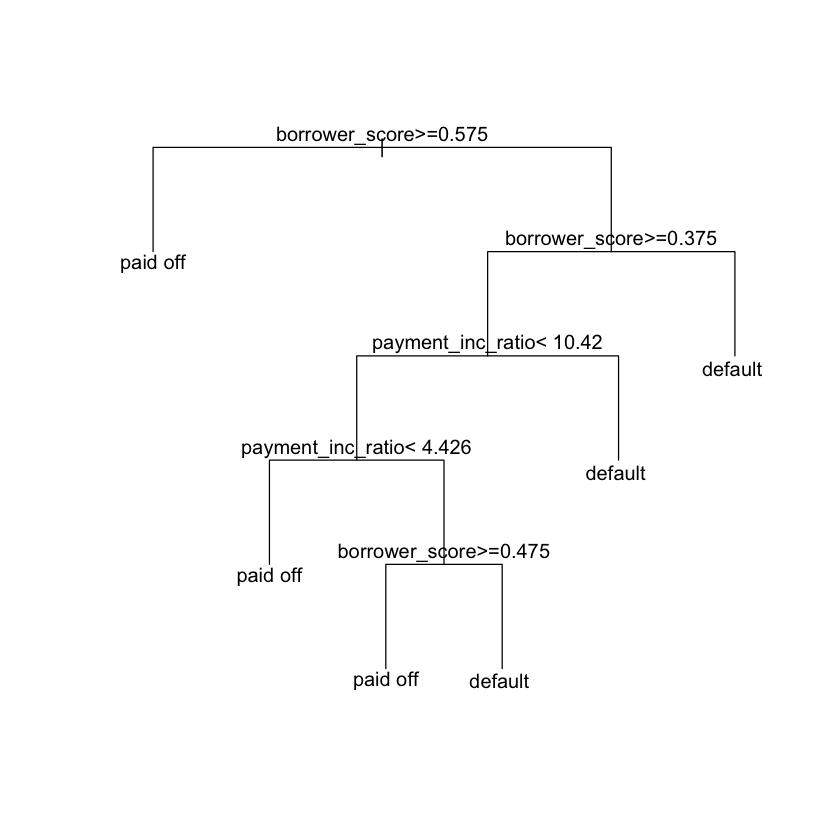

In [17]:
plot(loan_tree, uniform=TRUE, margin=0.05)
text(loan_tree)

In [18]:
loan_tree

n= 3000 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 3000 1445 paid off (0.5183333 0.4816667)  
   2) borrower_score>=0.575 878  261 paid off (0.7027335 0.2972665) *
   3) borrower_score< 0.575 2122  938 default (0.4420358 0.5579642)  
     6) borrower_score>=0.375 1639  802 default (0.4893228 0.5106772)  
      12) payment_inc_ratio< 10.42265 1157  547 paid off (0.5272256 0.4727744)  
        24) payment_inc_ratio< 4.42601 334  139 paid off (0.5838323 0.4161677) *
        25) payment_inc_ratio>=4.42601 823  408 paid off (0.5042527 0.4957473)  
          50) borrower_score>=0.475 418  190 paid off (0.5454545 0.4545455) *
          51) borrower_score< 0.475 405  187 default (0.4617284 0.5382716) *
      13) payment_inc_ratio>=10.42265 482  192 default (0.3983402 0.6016598) *
     7) borrower_score< 0.375 483  136 default (0.2815735 0.7184265) *

#### recursive partitioning algorithm 시각화 

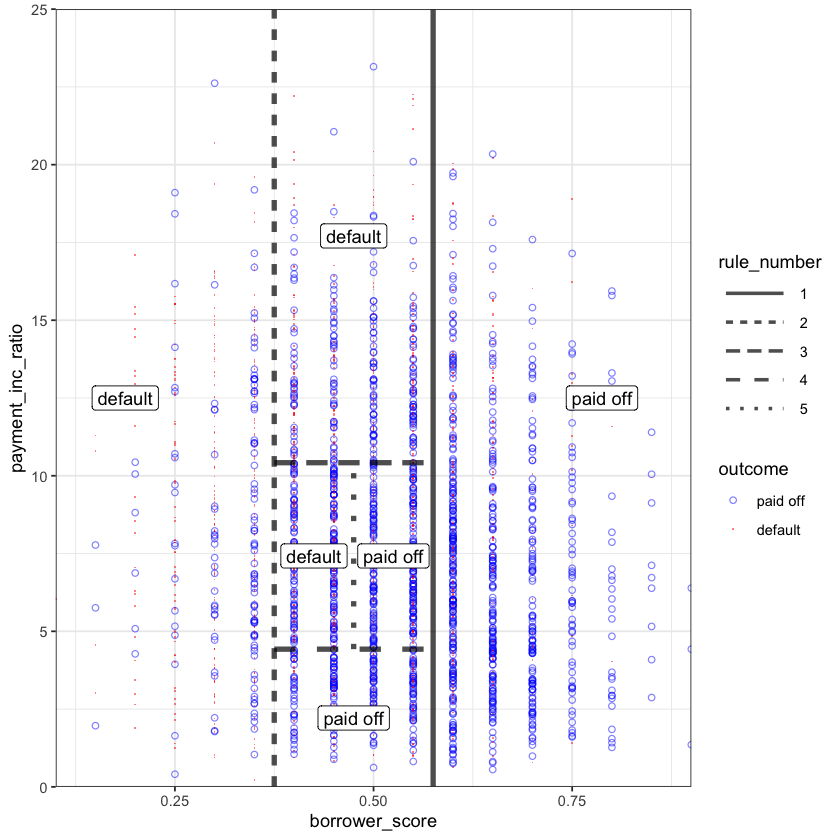

In [20]:
## Figure 6-4: View of partition rules
r_tree <- tibble(x1 = c(0.575, 0.375, 0.375, 0.375, 0.475),
                 x2 = c(0.575, 0.375, 0.575, 0.575, 0.475),
                 y1 = c(0,         0, 10.42, 4.426, 4.426),
                 y2 = c(25,       25, 10.42, 4.426, 10.42),
                 rule_number = factor(c(1, 2, 3, 4, 5)))
r_tree <- as.data.frame(r_tree)

rules <- tibble(x=c(0.575, 0.375, 0.4, 0.4, 0.475),
                y=c(24, 24, 10.42, 4.426, 9.42),
                rule_number = factor(c(1, 2, 3, 4, 5))) # , 3, 4, 5)))

labs <- tibble(x=c(.575 + (1-.575)/2, 
                   .375/2, 
                   (.375 + .575)/2,
                   (.375 + .575)/2, 
                   (.475 + .575)/2, 
                   (.375 + .475)/2
                   ),
               y=c(12.5, 
                   12.5,
                   10.42 + (25-10.42)/2,
                   4.426/2, 
                   4.426 + (10.42-4.426)/2,
                   4.426 + (10.42-4.426)/2
                   ),
               decision = factor(c('paid off', 'default', 'default', 'paid off', 'paid off', 'default')))

graph <- ggplot(data=loan3000, aes(x=borrower_score, y=payment_inc_ratio)) +
  geom_point( aes(color=outcome, shape=outcome), alpha=.5) +
  scale_color_manual(values=c('blue', 'red')) +
  scale_shape_manual(values = c(1, 46)) +
  geom_segment(data=r_tree, aes(x=x1, y=y1, xend=x2, yend=y2, linetype=rule_number), linewidth=1.5, alpha=.7) +
  guides(color = guide_legend(override.aes = list(linewidth=1.5)),
         linetype = guide_legend(keywidth=3, override.aes = list(linewidth=1))) +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0)) + 
  coord_cartesian(ylim=c(0, 25)) +
  geom_label(data=labs, aes(x=x, y=y, label=decision)) +
  #theme(legend.position='bottom') +
  theme_bw()
graph

### 6.3 Bagging & Random Forest

#### 랜덤 포레스트

In [11]:
rf <- randomForest(outcome ~ borrower_score + payment_inc_ratio, data=loan3000)

In [12]:
rf


Call:
 randomForest(formula = outcome ~ borrower_score + payment_inc_ratio,      data = loan3000) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 38.73%
Confusion matrix:
         paid off default class.error
paid off      963     592   0.3807074
default       570     875   0.3944637

In [13]:
str(rf)

List of 19
 $ call           : language randomForest(formula = outcome ~ borrower_score + payment_inc_ratio, data = loan3000)
 $ type           : chr "classification"
 $ predicted      : Factor w/ 2 levels "paid off","default": 2 2 1 1 2 1 2 2 1 2 ...
  ..- attr(*, "names")= chr [1:3000] "1" "2" "3" "4" ...
 $ err.rate       : num [1:500, 1:3] 0.415 0.422 0.418 0.407 0.407 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "OOB" "paid off" "default"
 $ confusion      : num [1:2, 1:3] 963 570 592 875 0.381 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "paid off" "default"
  .. ..$ : chr [1:3] "paid off" "default" "class.error"
 $ votes          : 'matrix' num [1:3000, 1:2] 0.335 0.342 0.522 0.708 0.127 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3000] "1" "2" "3" "4" ...
  .. ..$ : chr [1:2] "paid off" "default"
 $ oob.times      : num [1:3000] 182 190 178 178 181 195 172 160 181 171 ...
 $ classes        : chr [1:2] "paid off" "def

In [14]:
dim(rf$err.rate)

[1] 500   3

In [15]:
str(rf$err.rate)

 num [1:500, 1:3] 0.415 0.422 0.418 0.407 0.407 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "OOB" "paid off" "default"


In [18]:
# OOB error
error_df = data.frame(error_rate=rf$err.rate[, 'OOB'], num_trees=1:rf$ntree)

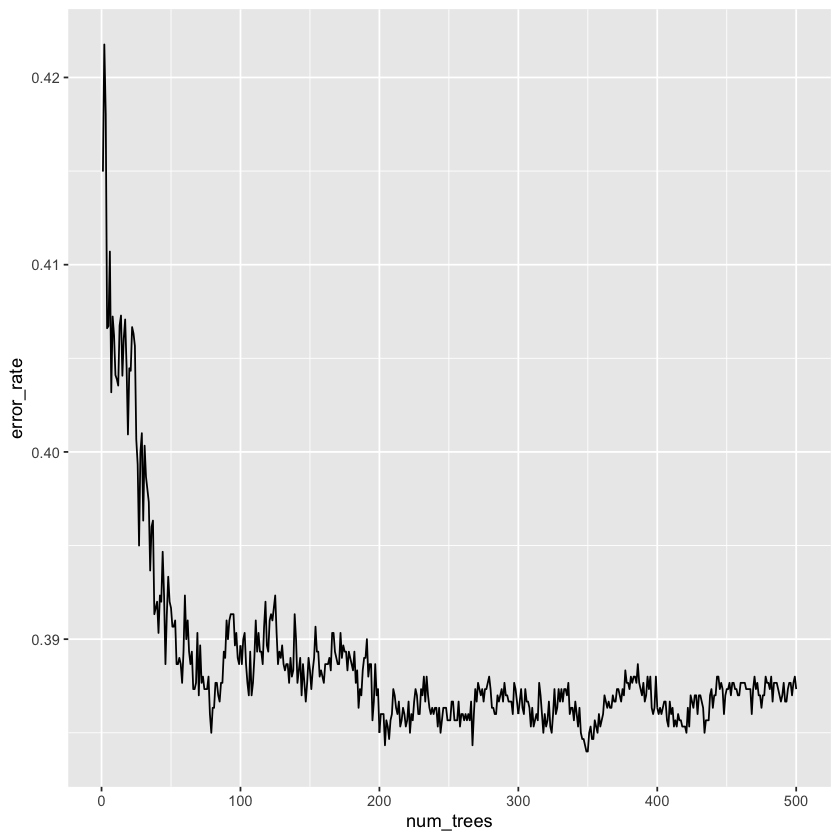

In [20]:
ggplot(error_df, aes(x=num_trees, y=error_rate)) + geom_line()

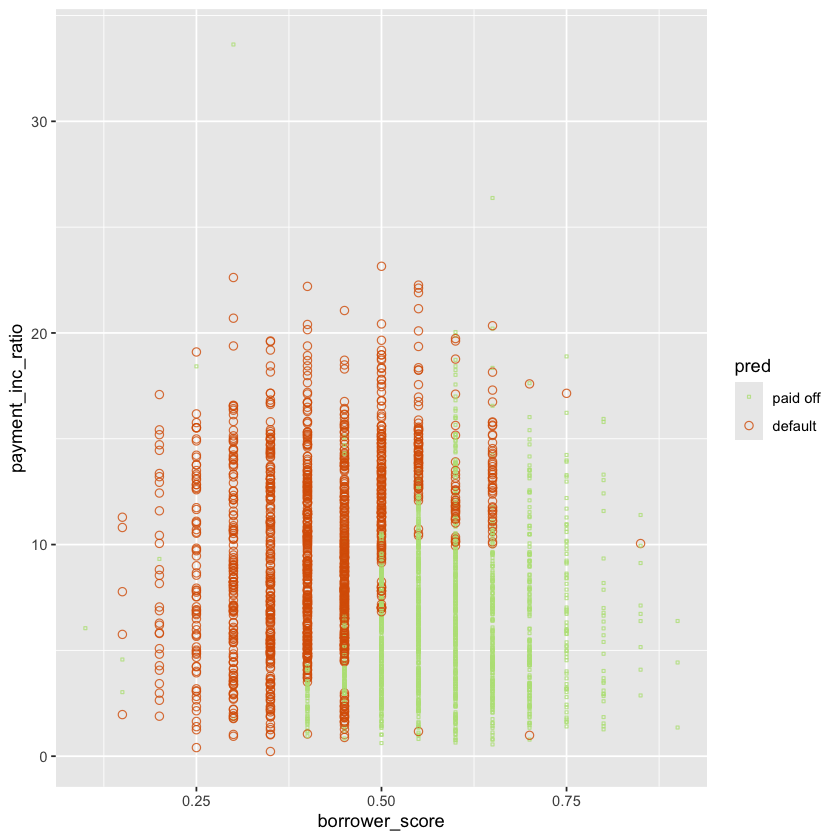

In [21]:
# 예측값 구하기
pred <- predict(rf, prob=TRUE)
rf_df <- cbind(loan3000, pred=pred)
ggplot(data=rf_df, aes(x=borrower_score, y=payment_inc_ratio, shape=pred, color=pred, size=pred)) +
    geom_point(alpha=.8) +
    scale_color_manual(values = c('paid off' = '#b8e186', 'default' = '#d95f02')) +
    scale_shape_manual(values = c('paid off' = 0, 'default' = 1)) +
    scale_size_manual(values = c('paid off' = 0.5, 'default' = 2))

#### 변수 중요도 

In [3]:
rf_all <- randomForest(outcome ~ ., data = loan_data, importance = TRUE) # . <- outcome 빼고 나머지 모든 칼럼을 예측 변수로 사용하겠다는 의미

In [4]:
rf_all


Call:
 randomForest(formula = outcome ~ ., data = loan_data, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 33.77%
Confusion matrix:
         paid off default class.error
paid off    14638    8033   0.3543293
default      7279   15392   0.3210710

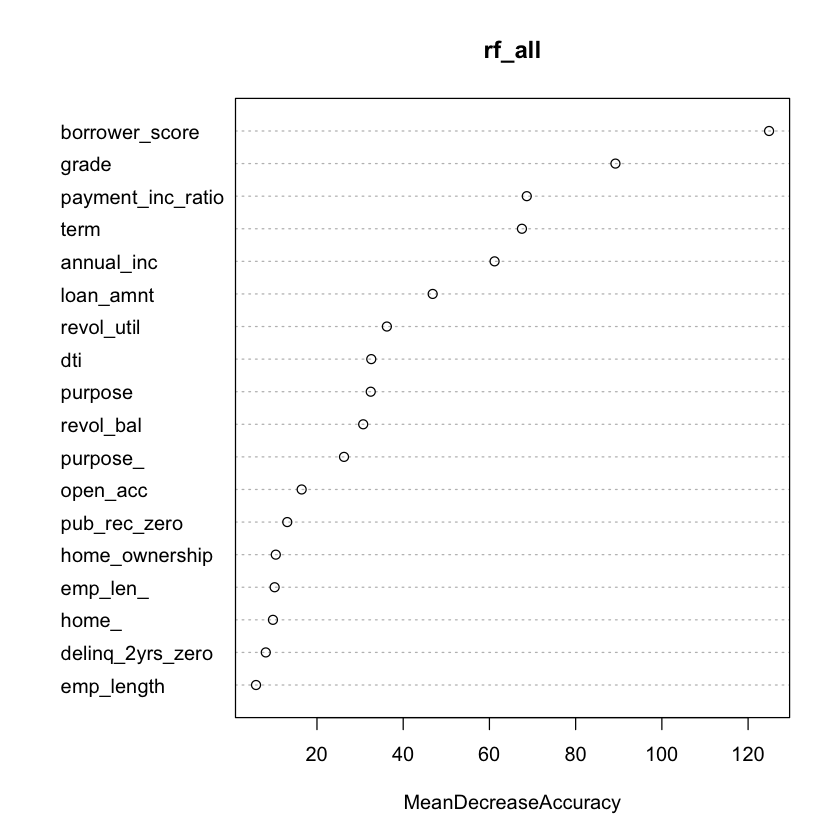

In [6]:
# 정확도의 평균 감소량 
varImpPlot(rf_all, type=1)

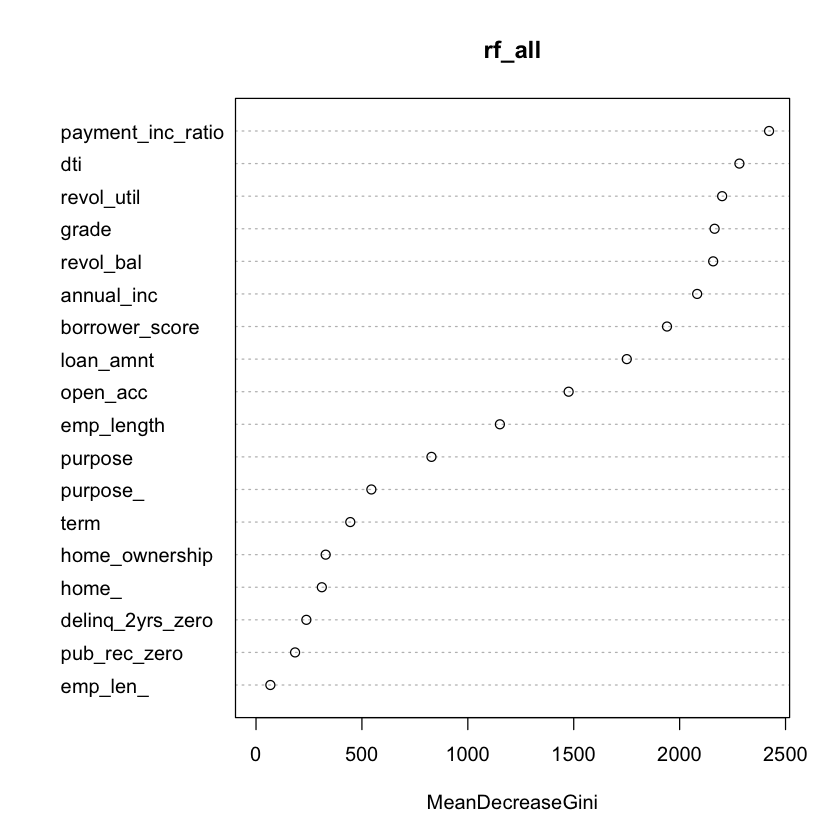

In [7]:
# 노드의 지니 불순도 평균 감소량 
varImpPlot(rf_all, type=2)

### 6.4 Boosting

In [3]:
predictors <- data.matrix(loan3000[, c('borrower_score', 'payment_inc_ratio')])
label <- as.numeric(loan3000[, 'outcome']) -1
xgb <- xgboost(data=predictors, label=label, objective="binary:logistic", params=list(subsample=0.64, eta=0.1), nrounds=100, eval_metric='error')

[1]	train-error:0.368000 
[2]	train-error:0.358333 
[3]	train-error:0.348333 
[4]	train-error:0.344667 
[5]	train-error:0.338667 
[6]	train-error:0.331667 
[7]	train-error:0.328333 
[8]	train-error:0.330667 
[9]	train-error:0.321333 
[10]	train-error:0.319000 
[11]	train-error:0.320333 
[12]	train-error:0.323667 
[13]	train-error:0.325333 
[14]	train-error:0.320333 
[15]	train-error:0.319000 
[16]	train-error:0.317667 
[17]	train-error:0.315667 
[18]	train-error:0.313333 
[19]	train-error:0.314333 
[20]	train-error:0.309667 
[21]	train-error:0.307000 
[22]	train-error:0.310667 
[23]	train-error:0.308667 
[24]	train-error:0.308667 
[25]	train-error:0.308667 
[26]	train-error:0.306667 
[27]	train-error:0.304667 
[28]	train-error:0.306333 
[29]	train-error:0.304333 
[30]	train-error:0.302000 
[31]	train-error:0.301667 
[32]	train-error:0.303667 
[33]	train-error:0.299667 
[34]	train-error:0.299000 
[35]	train-error:0.297000 
[36]	train-error:0.296667 
[37]	train-error:0.294333 
[38]	train

In [7]:
as.numeric(loan3000[, 'outcome'])

[1] 1 2 1 1 2 1 2 1 1 1 2 1 1 2 1 1 2 1 1 2 2 2 1 2 2 2 2 2 1 1 2 2 2 2 2 2 1
  [38] 2 2 2 1 1 2 2 1 1 1 1 1 2 2 2 2 2 1 2 1 1 1 2 2 1 2 1 2 2 2 1 1 2 1 1 1 2
  [75] 2 1 1 1 1 1 1 2 1 1 1 2 2 2 1 1 1 2 2 2 1 2 1 2 1 1 2 1 1 2 2 2 1 2 2 2 2
 [112] 2 2 1 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 2 2 2 1 2 2 1 1 1 2 2 1 2 2
 [149] 1 2 2 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2 2 2 1 2 2 2 2 2 2 2 1 1 1 1 1 2 1 2 1
 [186] 1 1 2 2 2 2 1 2 1 2 1 1 1 2 2 2 2 2 1 2 1 1 1 1 2 2 1 1 1 1 2 2 1 2 1 1 1
 [223] 2 2 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 1 2 2 2 1 1 1 2 2 2 1
 [260] 1 2 1 2 1 1 1 1 2 2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 2 1 1 2 1 2 2 2 1 2 1 2 1
 [297] 2 1 2 2 2 2 2 1 2 2 1 1 1 1 2 2 2 1 2 1 2 2 1 2 1 2 2 1 1 1 2 2 2 2 2 2 1
 [334] 1 1 1 2 2 2 1 1 2 1 2 2 2 2 2 1 1 2 2 1 1 1 2 1 2 2 1 2 2 2 2 1 1 1 1 1 2
 [371] 2 1 1 2 2 2 1 1 1 2 1 1 2 1 1 1 1 2 1 1 2 2 1 1 2 2 1 2 1 2 2 2 1 2 2 1 2
 [408] 1 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 2 1 2 2 1 2 1 1 1 1 2 2 1 1 2 1 1
 [445] 2 2 1 2 1 1 1 2 1 2 2 2 2 1 2 2 2 2 1 1 1 2 1 1 2 1 2 2 2 2 1 1 1 1 2 1 2
 [482] 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 2 2 2 1 2 2 1 2 2 2 2 1
 [519] 1 2 1 1 2 1 2 1 1 2 1 2 1 2 2 2 2 1 1 2 2 2 2 2 1 1 2 1 2 1 1 1 2 2 2 2 1
 [556] 2 2 1 1 1 1 1 2 1 1 2 2 2 2 1 2 1 1 1 2 1 2 1 2 2 2 2 2 2 2 1 2 1 1 1 2 1
 [593] 2 2 1 1 1 2 2 2 2 1 2 1 2 2 2 2 2 1 2 1 1 2 2 1 1 1 2 2 2 2 2 1 2 1 1 1 1
 [630] 1 1 2 1 1 1 1 2 1 2 1 2 1 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 2 2 1 1 2 1 1 2 1
 [667] 2 1 2 1 2 2 1 2 2 1 1 2 1 2 1 2 2 1 2 1 2 2 1 1 1 1 2 1 1 2 2 2 1 2 1 1 2
 [704] 1 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 2 2 1 2 1 2 2 1 2 1 1 2 2 1 1 2 1 2
 [741] 2 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 1 2 1 1 1 1 2 2 2
 [778] 2 1 2 1 2 2 2 2 2 1 1 2 2 1 2 2 2 1 2 2 2 1 1 1 1 2 1 1 2 2 2 1 1 2 1 1 2
 [815] 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 1 1 2 2 2 2 1 2 2 1 1 2 1 2 1 1 1 1 2
 [852] 2 2 1 1 2 2 1 1 1 2 2 1 2 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 2 2
 [889] 2 2 2 2 2 2 1 1 1 2 1 1 1 1 2 1 2 2 1 1 1 2 2 2 1 1 2 1 1 2 1 2 1 1 1 1 1
 [926] 1 1 2 2 2 1 2 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 2 2 2 1 2 1 2 1 1
 [963] 1 2 1 1 2 1 2 1 2 2 2 1 1 2 2 1 2 2 1 2 2 1 2 2 2 1 2 2 2 1 2 1 2 2 1 1 2
[1000] 1 1 1 1 2 2 2 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 2 1 1 2 2 2 1 2 1 2 1 1 1 2 1
[1037] 2 1 2 1 2 1 1 1 1 2 1 1 1 1 2 1 1 2 2 1 1 2 2 1 1 2 1 2 1 2 2 1 2 1 2 2 1
[1074] 2 2 2 2 1 2 1 2 1 2 1 1 1 1 2 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1 2 2 1 2 1 2 1
[1111] 2 2 2 1 2 1 2 1 2 1 1 1 2 1 1 1 1 2 1 2 2 1 2 1 1 2 1 1 1 1 1 1 2 2 2 2 1
[1148] 2 1 2 2 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 1 1 2 1 1 2 2 2 1 1 1 2 1 2
[1185] 2 2 2 2 2 1 2 2 1 2 1 1 2 2 2 2 1 2 1 2 2 1 1 2 1 1 2 2 1 2 2 1 2 2 2 1 1
[1222] 1 2 1 2 1 2 2 1 2 1 2 2 1 2 1 1 2 2 1 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 1 2 2
[1259] 1 2 2 1 2 1 1 1 2 2 1 2 1 1 2 2 1 2 2 2 2 1 2 2 2 1 2 2 1 1 2 2 2 1 2 1 2
[1296] 1 1 2 1 2 1 1 2 1 2 1 1 1 2 2 1 1 2 2 2 2 1 2 2 1 2 2 1 1 2 1 1 2 2 1 2 2
[1333] 1 2 2 1 1 2 2 1 1 1 1 1 1 2 2 2 1 1 2 2 2 1 1 1 2 1 1 2 1 1 2 2 1 1 2 1 1
[1370] 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 1 2 2 1 1 1
[1407] 1 2 1 1 2 2 1 1 1 1 1 2 1 1 2 1 2 1 2 2 1 2 2 2 1 1 2 2 1 2 2 1 2 1 2 1 2
[1444] 2 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 1 2 1 1 2 2 1 1 2 2 1 2 1 1
[1481] 1 1 2 2 1 1 2 1 2 1 1 2 2 2 2 1 1 2 1 1 1 2 2 1 1 2 2 1 1 2 2 1 2 1 1 2 1
[1518] 1 2 2 2 2 2 1 1 1 2 1 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 2 1 1 1 2 1 1 2 1 2 2
[1555] 1 1 1 2 2 2 1 2 1 1 2 2 1 2 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 2 1 1 1 2 1 1 1
[1592] 1 1 1 1 2 1 2 1 2 2 1 1 1 2 1 1 2 1 2 1 1 1 2 1 2 2 1 2 2 1 2 2 2 1 2 1 1
[1629] 2 1 2 2 1 2 1 1 2 1 2 1 1 2 1 2 1 1 2 2 1 2 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1
[1666] 1 2 1 1 2 1 2 1 1 1 1 1 1 2 1 1 2 2 2 1 1 1 1 2 1 1 1 1 2 1 1 2 1 1 2 1 2
[1703] 2 2 2 2 2 1 2 1 1 2 2 1 1 2 2 2 1 2 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1 2 1 2 2
[1740] 1 2 2 2 1 2 1 2 2 2 2 1 2 1 2 1 2 1 2 2 2 2 1 1 2 1 2 1 1 1 2 1 2 2 1 1 1
[1777] 1 1 1 1 2 1 2 2 2 2 2 2 1 2 1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 2 2 2 2 1 2 1 1
[1814] 2 1 1 2 2 2 1 1 2 1 2 2 2 2

In [8]:
str(loan3000)

'data.frame':	3000 obs. of  6 variables:
 $ X                : int  32109 16982 25335 34580 14424 35621 9920 42095 25219 26196 ...
 $ outcome          : Ord.factor w/ 2 levels "paid off"<"default": 1 2 1 1 2 1 2 1 1 1 ...
 $ purpose_         : Factor w/ 7 levels "credit_card",..: 2 1 2 4 2 2 2 2 2 2 ...
 $ dti              : num  21.2 15.5 27.3 21.1 16.5 ...
 $ borrower_score   : num  0.4 0.4 0.7 0.4 0.45 0.5 0.4 0.4 0.55 0.45 ...
 $ payment_inc_ratio: num  5.11 5.43 9.23 2.33 12.1 ...
